# ``UNet`` demo

The UNet is a classic go-to for semantic segmentation. To demonstrate it, we can use the VOCSegmentation dataset, which we can access through ``torchvision``.

To demonstrate how to use the model, we will use a brain MRI image segmentation dataset available on Kaggle, [here](https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation).

In [1]:
from pathlib import Path

data_dir = Path("/home/jim/storage/kaggle_3m/").resolve()

Now, let's get the images and targets as lists of paths. We will stick the data in a ``pandas.DataFrame`` to make it easier to split and examine, etc.

In [2]:
from torch_tools.file_utils import traverse_directory_tree

all_files = list(
    filter(
        lambda x: x.suffix == ".tif",
        traverse_directory_tree(data_dir),
    )
)

images = sorted(
    filter(lambda x: "mask" not in x.name, all_files),
    key=lambda x: x.name,
)

targets = sorted(
    filter(lambda x: "mask" in x.name, all_files),
    key=lambda x: x.name.replace("_mask", ""),
)

# Make sure the target and image names all match
assert all(map(lambda x: x[0].stem in x[1].stem, zip(images, targets)))

Now, let's put the image and target paths together in a ``pandas.DataFrame``.

In [3]:
from pandas import DataFrame

data = DataFrame(columns=["image", "target"], data=zip(images, targets))

valid_split = data.sample(frac=0.2, random_state=123)
train_split = data.loc[~data.index.isin(valid_split.index)]

print(train_split.shape, valid_split.shape)

(3143, 2) (786, 2)


Now we create datsets from the images.

In [4]:
from skimage.io import imread
from torchvision.transforms import Compose, ToTensor, ColorJitter

import matplotlib.pyplot as plt

from torch_tools import DataSet
from torch_tools.torch_utils import target_from_mask_img


train_img_tfms = Compose(
    [
        imread,
        ToTensor(),
        ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    ],
)
valid_img_tfms = Compose([imread, ToTensor()])

target_tfms = Compose(
    [imread, ToTensor(), lambda x: target_from_mask_img(x.squeeze(), 2)],
)


train_set = DataSet(
    inputs=train_split.image.to_list(),
    targets=train_split.target.to_list(),
    input_tfms=train_img_tfms,
    target_tfms=target_tfms,
)

valid_set = DataSet(
    inputs=train_split.image.to_list(),
    targets=train_split.target.to_list(),
    input_tfms=valid_img_tfms,
    target_tfms=target_tfms,
)

Let's plot an example image–target pair.

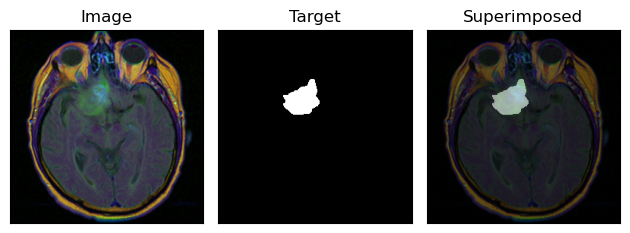

In [5]:
img, tgt = train_set[2]

tgt = tgt.argmax(dim=0)


figure, axes = plt.subplots(1, 3)

axes[0].imshow(img.permute(1, 2, 0))
axes[1].imshow(tgt, cmap="Greys_r")

axes[2].imshow(img.permute(1, 2, 0))
axes[2].imshow(tgt, cmap="Greys_r", alpha=0.5)


for axis, title in zip(axes.ravel(), ["Image", "Target", "Superimposed"]):
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_title(title)

figure.tight_layout()

Now we can wrap the ``DataSet``s in ``DataLoader``s and set about training the model.

In [6]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_set, shuffle=False, batch_size=batch_size)

Now we need a model, optimiser, loss function and training loops.

In [7]:
from torch.optim import Adam
from torch.nn import BCELoss
from torch.cuda import is_available

from torch_tools import UNet

DEVICE = "cuda" if is_available() else "cpu"

model = UNet(
    in_chans=3,
    out_chans=2,
    features_start=32,
).to(DEVICE)

optimiser = Adam(model.parameters(), lr=1e-4)

loss_func = BCELoss()

Now lets write our training and validation loops.

In [8]:
from torch import no_grad


def train_single_epoch(
    model: UNet,
    loss_func: BCELoss,
    optimiser: Adam,
    train_loader: DataLoader,
):
    """Train the model for a single epoch.

    Parameters
    ----------
    model : UNet
        The ``torch_tools.UNet`` model.
    loss_func : BCELoss
        Binary-cross-entropy loss function.
    optimiser : Adam
        Adam optimiser.
    train_loader : DataLoader
        Training data loader.

    Returns
    -------
    mean_loss : float
        Mean loss per pixel.
    mean_acc : float
        A measure of the mean pixel-level accuracy.

    """
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    for batch, target in train_loader:
        optimiser.zero_grad()

        batch, target = batch.to(DEVICE), target.to(DEVICE)

        prediction = model(batch).softmax(dim=1)

        loss = loss_func(prediction, target)

        loss.backward()

        optimiser.step()

        running_loss += loss.item()

        running_acc += (
            (prediction.cpu().argmax(dim=1) == target.cpu().argmax(dim=1))
            .float()
            .mean()
        )

    mean_loss = running_loss / len(train_loader)
    mean_acc = running_acc / len(train_loader)

    return mean_loss, mean_acc


@no_grad()
def validate_single_epoch(
    model: UNet,
    loss_func: BCELoss,
    valid_loader: DataLoader,
):
    """Validate the model for a single epoch.

    Parameters
    ----------
    model : UNet
        The ``torch_tools.UNet`` model.
    loss_func : BCELoss
        Binary-cross-entropy loss function.
    valid_loader : DataLoader
        Validation data loader.
    mean_acc : float
        A measure of the mean pixel-level accuracy.

    Returns
    -------
    mean_loss : float
        Mean loss per pixel.

    """
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    for batch, target in valid_loader:
        batch, target = batch.to(DEVICE), target.to(DEVICE)

        prediction = model(batch).softmax(dim=1)

        loss = loss_func(prediction, target)

        running_loss += loss.item()

        running_acc += (
            (prediction.cpu().argmax(dim=1) == target.cpu().argmax(dim=1))
            .float()
            .mean()
        )

    mean_loss = running_loss / len(train_loader)
    mean_acc = running_acc / len(train_loader)

    return mean_loss, mean_acc

Now we can train the model.

In [9]:
num_epochs = 30

training_loss, validation_loss = [], []
training_acc, validation_acc = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_single_epoch(
        model,
        loss_func,
        optimiser,
        train_loader,
    )
    valid_loss, valid_acc = validate_single_epoch(
        model,
        loss_func,
        valid_loader,
    )

    training_loss.append(train_loss)
    validation_loss.append(valid_loss)
    training_acc.append(train_acc)
    validation_acc.append(valid_acc)

Now we can plot the training metrics.

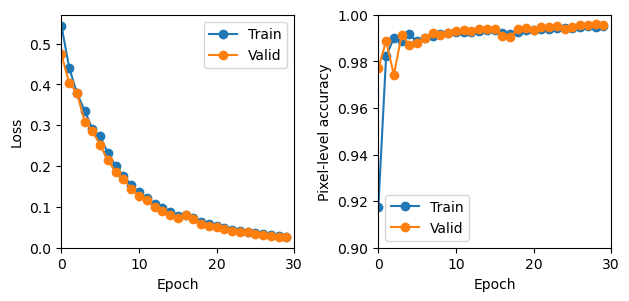

In [10]:
figure, axes = plt.subplots(1, 2)

axes[0].plot(training_loss, "-o", label="Train")
axes[0].plot(validation_loss, "-o", label="Valid")

axes[1].plot(training_acc, "-o", label="Train")
axes[1].plot(validation_acc, "-o", label="Valid")


axes[0].set_ylabel("Loss")
axes[1].set_ylabel("Pixel-level accuracy")


axes[0].set_ylim(bottom=0.0)
axes[1].set_ylim(bottom=0.90, top=1.0)


for axis in axes.ravel():
    axis.set_xlim(left=0.0, right=len(training_loss))
    axis.legend()

    axis.set_xlabel("Epoch")

    axis.set_aspect(
        (axis.get_xlim()[1] - axis.get_xlim()[0])
        / (axis.get_ylim()[1] - axis.get_ylim()[0])
    )


figure.tight_layout()

While we are using the pixel-level accuracy as a metric, you should not be decieved by how quickly it becomes high. Remeber, even in the images with tumours, the number of positive pixels makes up only a small fraction of the total number of pixel. Thus, a model which simply guessed that every single pixel is negative would still yeild a reasonably high accuracy. Nevertheless, both the loss and accuracy progress with the number of epochs in a reasonable fashion. Let's now visualise some predictions.

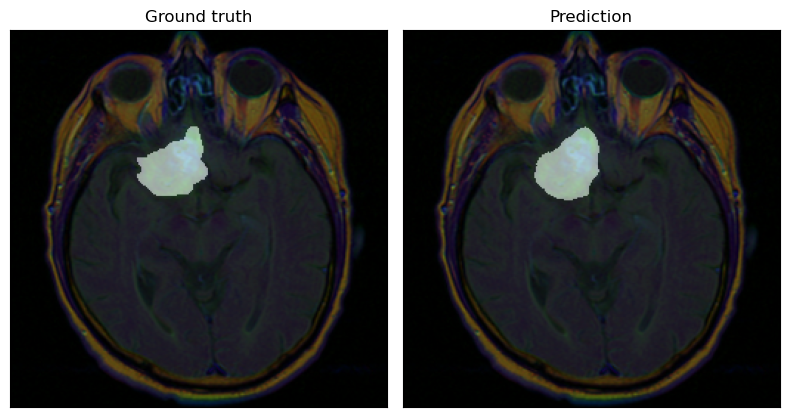

In [11]:
model.to("cpu")
model.eval()
prediction = model(img.unsqueeze(0)).softmax(dim=1).argmax(dim=1).squeeze(0)

figure, axes = plt.subplots(1, 2, figsize=(8, 16))

axes[0].imshow(img.permute(1, 2, 0))
axes[0].imshow(tgt, cmap="Greys_r", alpha=0.5)

axes[1].imshow(img.permute(1, 2, 0))
axes[1].imshow(prediction.float(), cmap="Greys_r", alpha=0.5)

axes[0].set_title("Ground truth")
axes[1].set_title("Prediction")


for axis in axes.ravel():
    axis.set_xticks([])
    axis.set_yticks([])

figure.tight_layout()